# AirBnb for Madrid

In [1]:
import requests
import pandas
import numpy
import geopandas
import geopy
import contextily
import json
import matplotlib.pyplot as plt

## Download files

- Path to file

In [2]:
url = (
    "http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/"\
    "2020-12-17/data/listings.csv.gz"
)
url

'http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2020-12-17/data/listings.csv.gz'

- Download

In [3]:
%time lst = pandas.read_csv(url)

CPU times: user 714 ms, sys: 186 ms, total: 900 ms
Wall time: 10.9 s


## Parse columns

### Prices

In [4]:
lst["price_usd"] = lst["price"].apply(
    lambda p: float(
        str(p).replace(",", "").strip("$")
    )
)
lst["log1p_price_usd"] = numpy.log1p(lst["price_usd"])

### Amenities

We will pick the following ones:

- Netflix
- WiFi
- Coffee maker
- Gym
- Parking

For this we define a `finder` method:

In [5]:
%%time
parser = lambda s: s.lower()\
                    .replace(" ", "")\
                    .replace(",", "")
def amenity_finder(term, amenities):
    pterm = parser(term)
    for amenity in amenities:
        if pterm in parser(amenity):
            return 1
    return 0

ams = set()
amenity_cols = [
    "WiFi", "Coffee", "Gym", "Parking"
]
# Set up containers for new columns
for new_col in amenity_cols:
    lst[new_col] = None
# Pull out amenities
for i, row in lst.iterrows():
    r = json.loads(row['amenities'])
    for amenity_col in amenity_cols:
        lst.loc[i, amenity_col] = amenity_finder(
            amenity_col, r
        )
    ams.update(set(r))

lst[amenity_cols].sum()

CPU times: user 34.1 s, sys: 0 ns, total: 34.1 s
Wall time: 34.1 s


WiFi       19263
Coffee      8972
Gym          474
Parking     8497
dtype: object

We can plot the distribution of those which have and don't have each amenity:

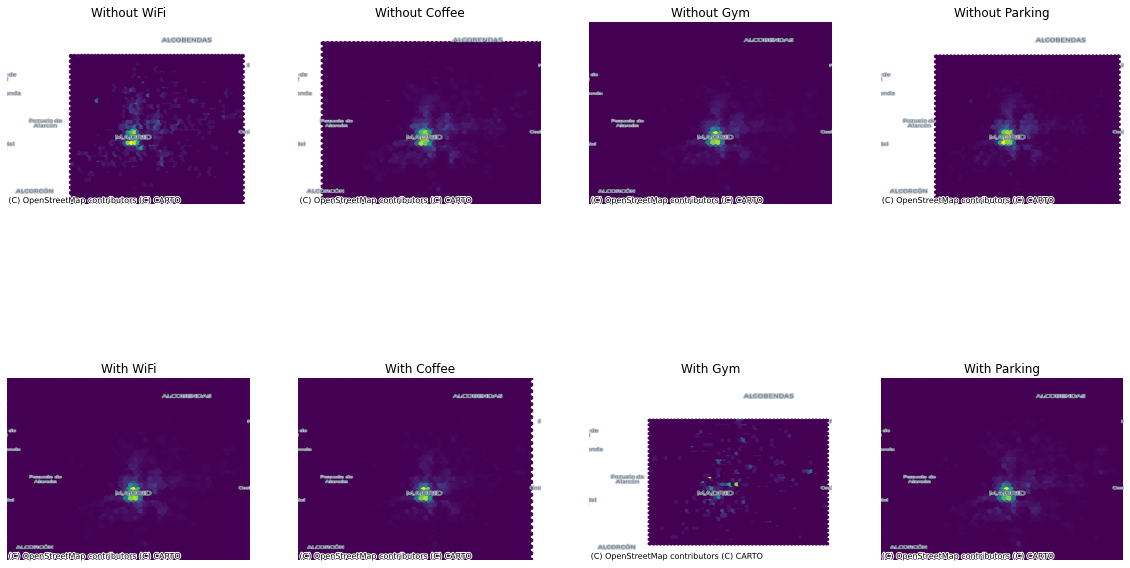

In [6]:
f, axs = plt.subplots(2, 4, figsize=(20, 12))
for j in range(len(amenity_cols)):
    amenity = amenity_cols[j]
    for i in range(2):
        ax = axs[i, j]
        lst.query(f"{amenity} == {i}")\
           .plot.hexbin(
            "longitude", 
            "latitude", 
            xlim=(lst["longitude"].min(), lst["longitude"].max()),
            ylim=(lst["latitude"].min(), lst["latitude"].max()),
            gridsize=50, 
            ax=ax, 
            cmap="viridis", 
            colorbar=False
        )
        t = "With"
        if i == 0:
            t += "out"
        t += f" {amenity}"
        lbls = contextily.providers.CartoDB.VoyagerOnlyLabels
        contextily.add_basemap(
            ax, crs="EPSG:4326", source=lbls, zoom=11
        )
        ax.set_title(t)
        ax.set_axis_off()

## Clean `bathrooms`

`bathrooms_text` is non numeric and would be good to have as a count. The current values are:

In [7]:
lst["bathrooms_text"].unique()

array(['1 shared bath', '1 bath', '2 baths', '1.5 baths',
       '1 private bath', nan, '1.5 shared baths', '2 shared baths',
       '2.5 baths', 'Shared half-bath', 'Half-bath', '0 baths', '4 baths',
       '3 baths', '0 shared baths', '2.5 shared baths', '3.5 baths',
       '5 baths', '3 shared baths', '6 baths', '5.5 baths',
       '4.5 shared baths', '4.5 baths', '6 shared baths',
       '8 shared baths', '6.5 baths', '5.5 shared baths',
       '4 shared baths', '3.5 shared baths', 'Private half-bath',
       '5 shared baths', '6.5 shared baths', '7 baths', '11 baths',
       '11 shared baths', '8 baths', '10 baths', '14 baths'], dtype=object)

To conver, we will simply remove the part with text, and convert the remaining "half-bath" to `0.5`.

In [8]:
def bathroom_parser(s):
    try:
        return float(s.split(" ")[0])
    except:
        try:
            if "halfbath" in s.lower().replace(" ", "").replace("-", ""):
                return 0.5
            else:
                return numpy.nan
        except:
            return numpy.nan

lst["bathrooms"] = lst["bathrooms_text"].apply(bathroom_parser)

## Subset

- Variables to keep

In [9]:
vars_to_keep = [
    "price",
    "price_usd",
    "log1p_price_usd",
    "accommodates",
    "bathrooms_text",
    "bathrooms",
    "bedrooms",
    "beds",
    "neighbourhood_cleansed",
    "room_type",
    "property_type",
    "WiFi",
    "Coffee",
    "Gym",
    "Parking",
]

- Point geometries

In [10]:
pts = geopandas.points_from_xy(
    lst["longitude"], lst["latitude"]
)

- One table with clearer names

In [11]:
db = geopandas.GeoDataFrame(
    lst[vars_to_keep],
    geometry = pts,
    crs = "EPSG:4326"
).rename(columns= {
    "neighbourhood_cleansed": "neighbourhood"
})

## Distance to El Retiro

- Locate the park

In [12]:
geocoder = geopy.geocoders.Nominatim(user_agent="El_Retiro")
er = geocoder.geocode("El Retiro, Madrid, Spain")
er

Location(Retiro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España, (40.4111495, -3.6760566, 0.0))

- Project the point to Spanish CRS (in metres)

In [13]:
sp_crs = "EPSG:25830"
er_pt = geopandas.GeoSeries(
    geopandas.points_from_xy(
        [er.longitude], [er.latitude],
        crs = "EPSG:4326"
    )
).to_crs(sp_crs)

- Distances (in Km)

In [14]:
dists = db.to_crs(sp_crs)\
          .distance(
    geopandas.GeoSeries(
        er_pt.loc[0], index=db.index, crs=er_pt.crs
    )
) / 1000

- Add to table

In [15]:
db["km_to_retiro"] = dists

## Write out



- Only _full_ rows

In [16]:
out_p = "madrid_abb.gpkg"
! rm $out_p
db.dropna().to_file(out_p, driver="GPKG")

## Download link

[`[Download]`](madrid_abb.gpkg)